In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from scipy.stats import boxcox
%matplotlib inline
import os

In [2]:
os.chdir(r'd:\ml\временные ряды\Series')
# оставляем два ряда - стационарный
female_births = pd.read_csv("daily-total-female-births-in-cal.csv")
# нестационарный
airlines_passengers = pd.read_csv("international-airline-passengers.csv")

In [3]:
all_series = {
    "International airline passengers: monthly totals in thousands": airlines_passengers["Count"],
    "Daily total female births in California": female_births["Count"]
}

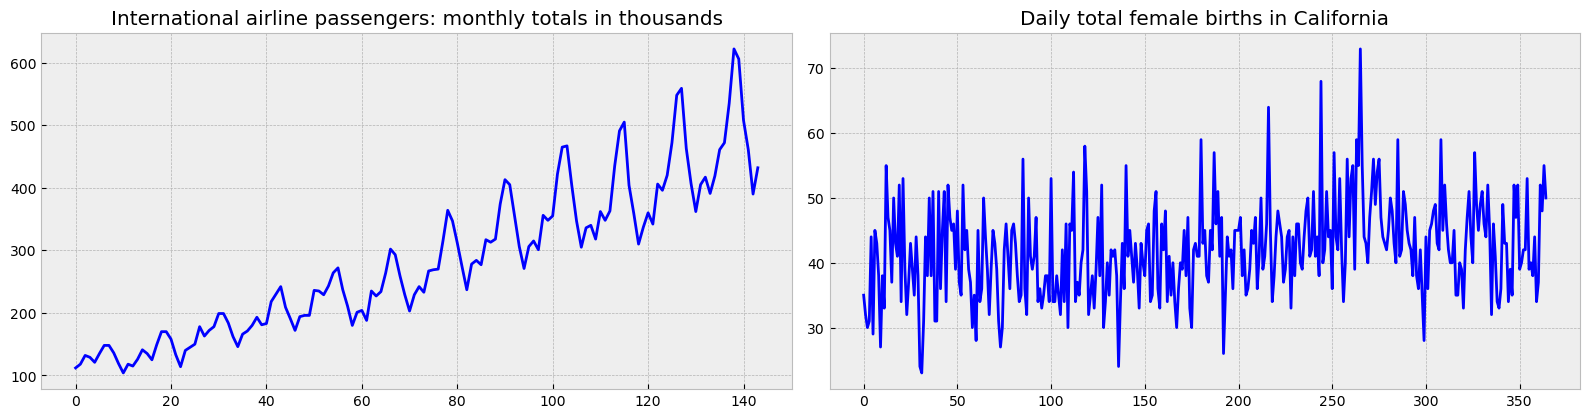

In [4]:
with plt.style.context('bmh'):
    plt.figure(figsize=(16, 8))
    layout = (2, 2)
    for i, key in enumerate(all_series.keys()):
        x = i % 2
        y = int((i - x) / 2)
        
        ts_ax = plt.subplot2grid(layout, (y, x))
        all_series[key].plot(ax=ts_ax, color='blue')
        ts_ax.set_title(key)
        
    plt.tight_layout()

In [5]:
def plot_ts_and_points(tser, start_point, step):
    new_series = [None for i in range(len(tser))]
    for i in range(len(tser)):
        pos = start_point + step * i
        if pos >= len(tser):
            break
        new_series[pos] = tser[pos]
    new_series = pd.Series(new_series)
    
    with plt.style.context('bmh'):
        plt.figure(figsize=(16, 8))
        ts_ax = plt.axes()
        tser.plot(ax=ts_ax, color='blue')
        new_series.plot(ax=ts_ax, style='ro')

In [6]:
def tsplot(y, lags=None, figsize=(14, 8), style='bmh', tsname ='Original'):
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (4, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title(tsname)

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)

        plt.tight_layout()
    return

In [7]:
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

# Скользящее среднее на нестационарном ряде

In [8]:
def moving_average(series, n):
    if not isinstance(series, pd.Series):
        series = pd.Series(series)
    return series.rolling(n).mean()

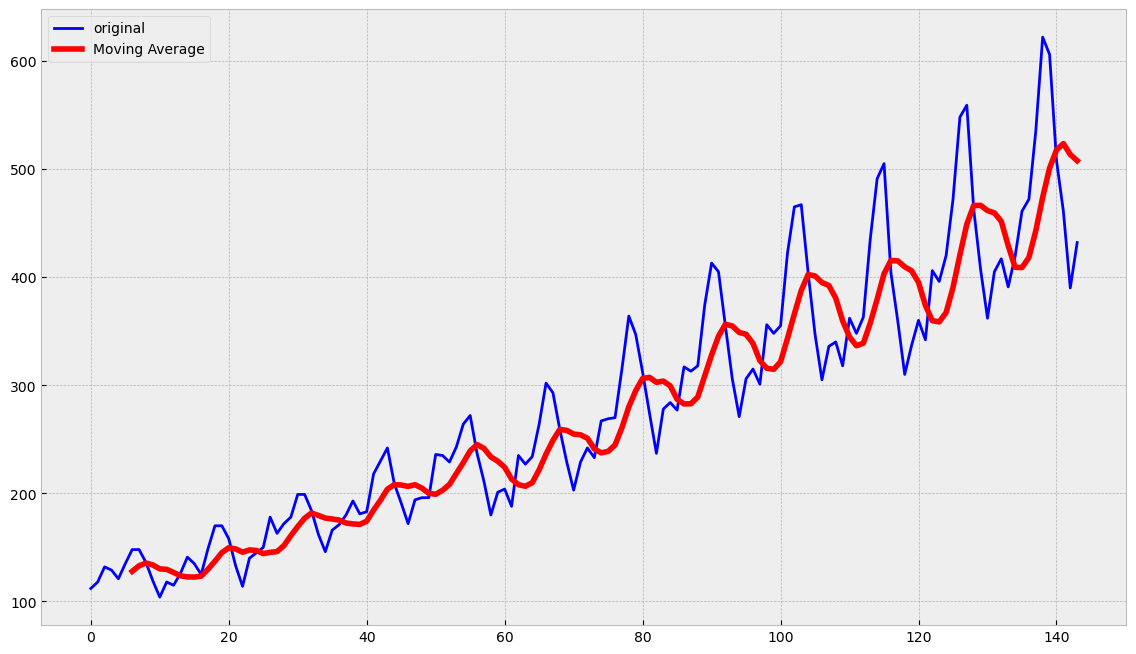

In [9]:
ts = pd.read_csv("international-airline-passengers.csv")['Count']
ser = moving_average(ts, 7)
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(ts, color='blue',label='original')
    plt.plot(ser, color='red', linewidth='4', label='Moving Average')
    plt.legend()

# Скользящее среднее на стационарном ряде

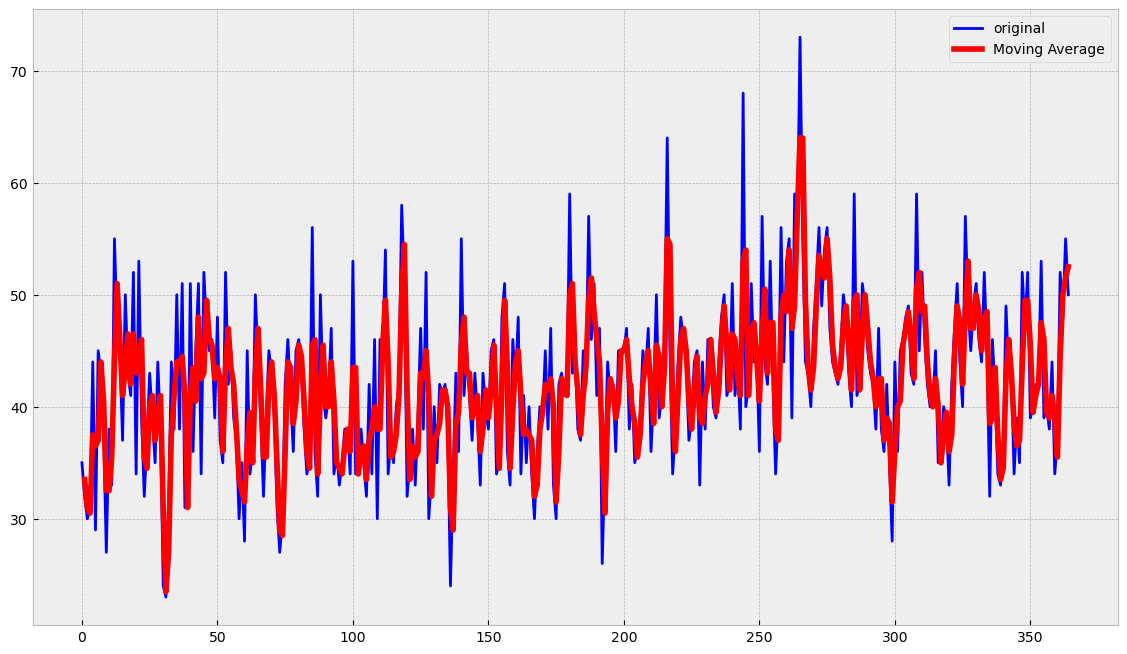

In [10]:
ts = pd.read_csv("daily-total-female-births-in-cal.csv")['Count']
ser = moving_average(ts, 2)
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(ts, color='blue',label='original')
    plt.plot(ser, color='red', linewidth='4', label='Moving Average')
    plt.legend()

По сути MA сглаженный график с запаздываением на нестационарном ряде. На стационарном ряде остаются выбросы и MA не приближается к графику. При уменьшении размера окна для скользящего среднего на 2 все равно остаются выбросы и график MA не сильно приближается к оригиналу. EMA, и MA, WMA — индикаторы тренда и не будут работать (мое мнение) на стационарном ряду.

Чем больше размер "окна" скользящего среднего $n$ тем более сглаженным получается результат. 


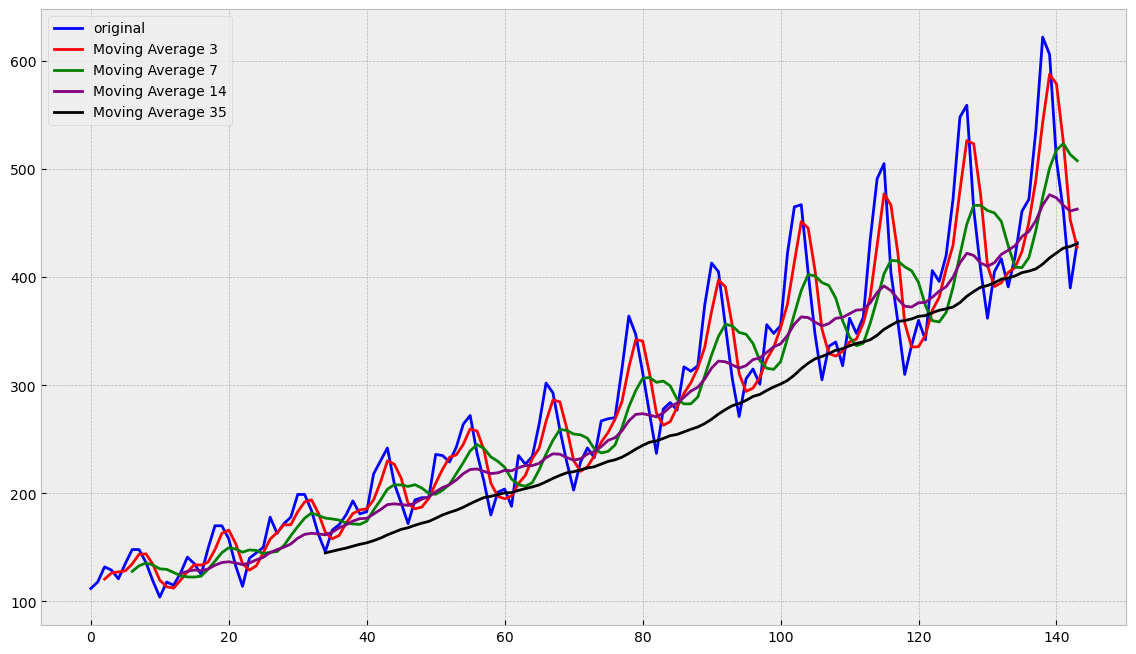

In [11]:
ts = еairlines_passengers = pd.read_csv("international-airline-passengers.csv")['Count']
nplt = 'Series/international-airline-passengers'

windows = [3,7,14,35]
colors = ['red', 'green', 'purple', 'black']
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(ts, color='blue',label='original')
    for i in range(len(windows)):
        ser = moving_average(ts, windows[i])
        plt.plot(ser, color=colors[i], linewidth='2', label='Moving Average {}'.format(windows[i]))
    plt.legend()

Скользящая средняя - всегда запаздывание от оригинала. Приблизить график скользящей к оригиналу будем пробовать на двойном и тройном экспоненциальном сглаживании.

# Двойное экспоненциальное сглаживание

In [12]:
def double_ema(series, alpha, beta):
    result = [series[0]]
    level, trend = series[0], series[1] - series[0]
    for n in range(1, len(series)):
        value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
    return pd.Series(result)

In [13]:
def plot_dema(alpha, beta):
    dema = double_ema(ts, alpha, beta)
    with plt.style.context('bmh'):
        plt.figure(figsize=(14, 8))
        plt.plot(ts, color='blue',label='original')
        plt.plot(dema, color='red', linewidth='4', label='DEMA')
        plt.title("alpha={}, beta={}".format(alpha, beta))
        plt.legend()

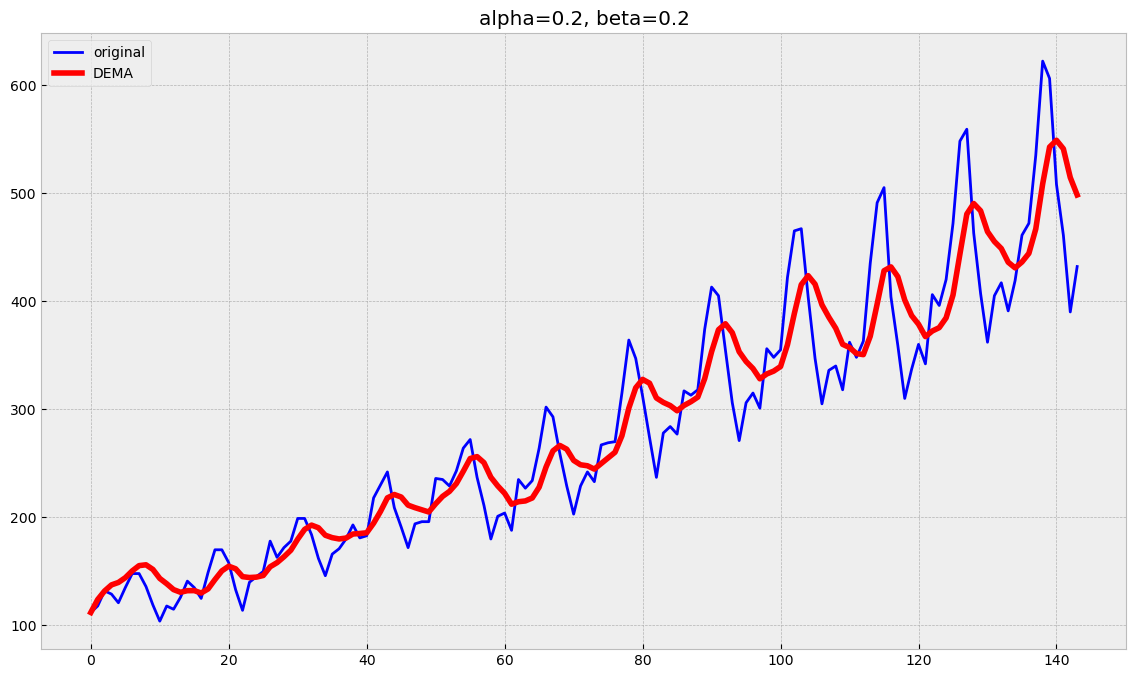

In [14]:
plot_dema(0.2, 0.2)

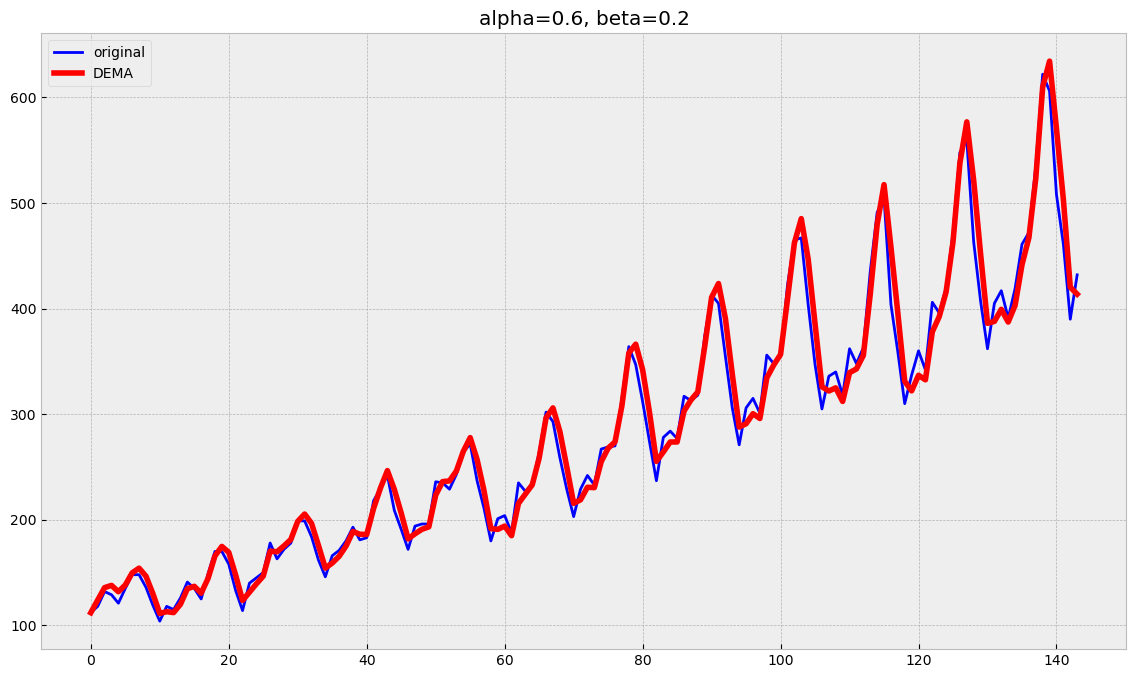

In [15]:
plot_dema(0.6, 0.2)

alpha отвечает за сглаживание ряда вокруг тренда, beta - за сглаживание самого тренда. Чем больше значения, тем более значимыми будут последние наблюдения и менее значимой будет история.
Добавим сезонность

# Хольт-Винтерс

In [16]:
def initial_trend(series, season_len):
    return sum([float(series[i + season_len] - series[i]) / season_len]) / season_len

In [17]:
def initial_seasonal_components(series, slen):
    seasonals = {}
    season_averages = []
    n_seasons = int(len(series)/slen)
    # compute season averages
    for j in range(n_seasons):
        season_averages.append(sum(series[slen*j:slen*j+slen])/float(slen))
    # compute initial values
    for i in range(slen):
        sum_of_vals_over_avg = 0.0
        for j in range(n_seasons):
            sum_of_vals_over_avg += series[slen*j+i]-season_averages[j]
        seasonals[i] = sum_of_vals_over_avg/n_seasons
    return seasonals

In [18]:
def triple_exponential_smoothing(series, slen, alpha, beta, gamma, n_preds):
    result = []
    seasonals = initial_seasonal_components(series, slen)
    for i in range(len(series)+n_preds):
        if i == 0: # initial values
            smooth = series[0]
            trend = initial_trend(series, slen)
            result.append(series[0])
            continue
        if i >= len(series): # we are forecasting
            m = i - len(series) + 1
            result.append((smooth + m*trend) + seasonals[i%slen])
        else:
            val = series[i]
            last_smooth, smooth = smooth, alpha*(val-seasonals[i%slen]) + (1-alpha)*(smooth+trend)
            trend = beta * (smooth-last_smooth) + (1-beta)*trend
            seasonals[i%slen] = gamma*(val-smooth) + (1-gamma)*seasonals[i%slen]
            result.append(smooth+trend+seasonals[i%slen])
    return result

In [19]:
def plot_tema(alpha, beta, gamma, ser=ts, ser_to_plot=ts, n_preds=24):
    tema = triple_exponential_smoothing(ser, 12, alpha, beta, gamma, n_preds)
    with plt.style.context('bmh'):
        plt.figure(figsize=(14, 8))
        plt.plot(ser_to_plot, color='blue',label='original')
        plt.plot(tema, color='red', linewidth='4', label='TEMA')
        plt.title("alpha={}, beta={}, gamma={}".format(alpha, beta, gamma))
        plt.legend()

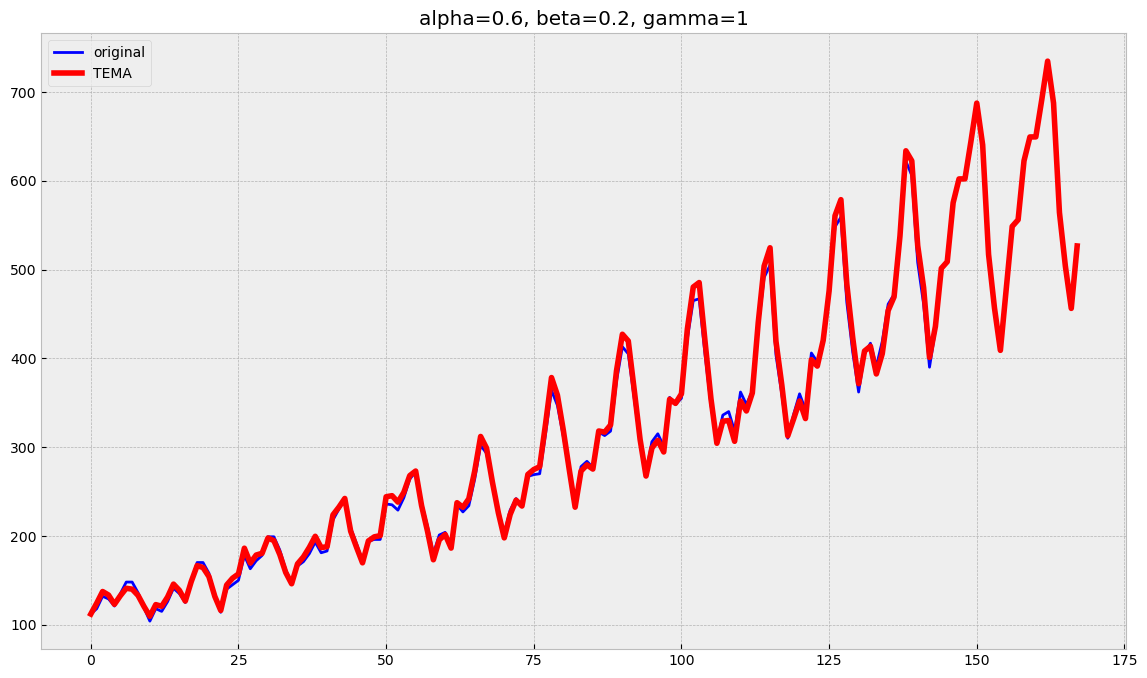

In [20]:
plot_tema(0.6, 0.2, 1)

# Подбор параметров

Что значит, что наша модель лучше всего приближает исходные данные? Это значит, что минимизируется некоторая функция ошибки. Мы, для простоты, будет считать стандарнтый RMSE:

$RMSE =  \sqrt {1/n \sum^N_{i=1} (\hat{y}_i - y_i)^2}$

Алгоритм поиска стандартный - метод градиентного спуска. Считаем производный по каждому из параметров и спускаемся в сторону минимума.

In [21]:
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error

In [22]:
series = ts

In [23]:
train, test, val = series[:70], series[70:85], series[85:]

In [24]:
def mse(X):
    alpha, beta, gamma = X
    result = triple_exponential_smoothing(train, 12, alpha, beta, gamma, len(test))
    predictions = result[-len(test):]
    error = mean_squared_error(predictions, test)
    return error

In [25]:
opt = minimize(mse, x0=[0,0,0], method="L-BFGS-B", bounds = ((0, 1), (0, 1), (0, 1)))

In [26]:
alpha_opt, beta_opt, gamma_opt = opt.x
print(opt)

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 67.0871099655068
        x: [ 1.469e-01  3.139e-01  9.564e-01]
      nit: 30
      jac: [ 3.506e-03  1.501e-03  1.165e-04]
     nfev: 152
     njev: 38
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>


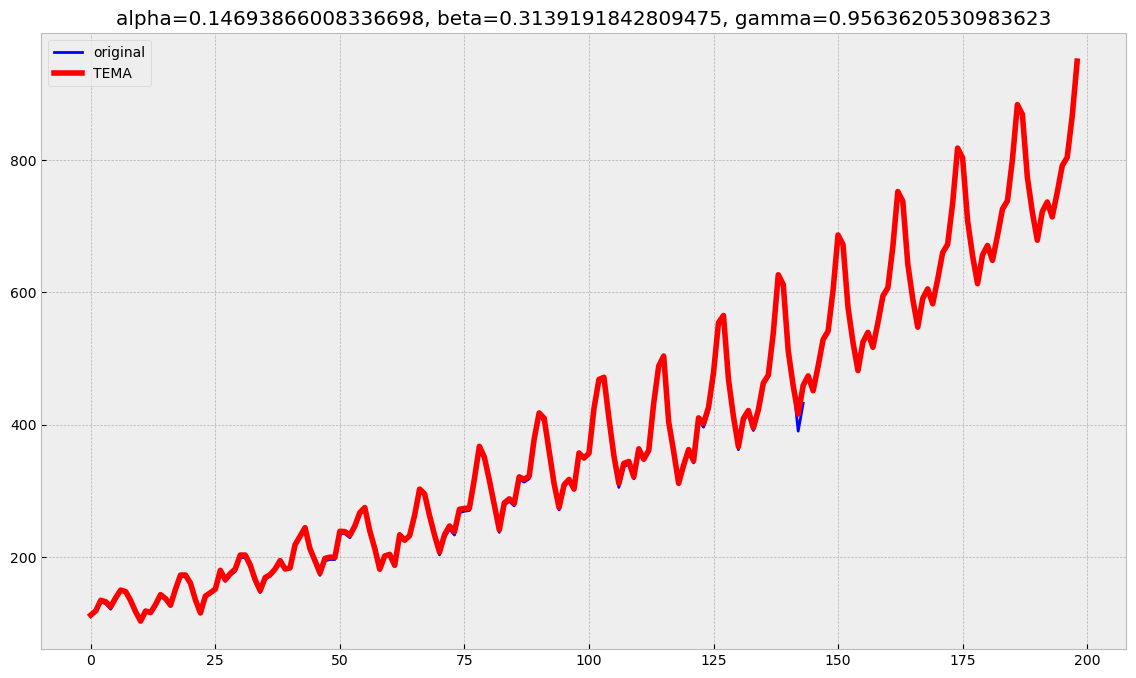

In [27]:
plot_tema(alpha_opt, beta_opt, gamma_opt, ser=series[:140], ser_to_plot=series, n_preds=len(val))

In [28]:
len (val)

59

# Кросс-валидация

Проблема кросс-валидации на временных рядах состоит в том, что случайно перемешивать в фолдах значения всего ряда нельзя. Т.к. он имеет временную структуру, и ее надо сохранять (иначе потеряются все взаимосвязи наблюдений);

Будем делать кросс-валидацию на скользящем окне.

Суть достаточно проста:
1. Берем t измерений
2. Делаем прогноз на n измерений вперед и считаем ошибку
3. Берем t+n измерений
4. Делаем прогноз на n измерений вперед и считаем ошибку
5. Берем t+2*n измерений
6. Делаем прогноз на n измерений вперед и считаем ошибку
...

In [29]:
train, val = series[:125], series[125:]

In [30]:
from sklearn.model_selection import TimeSeriesSplit

def mse_cross_val(X):
    alpha, beta, gamma = X
    split = TimeSeriesSplit(n_splits=3) 
    errors = []
    
    for train_split, test_split in split.split(train):
        train_split_ts = train.iloc[train_split]
        test_split_ts = train.iloc[test_split]
#         print(train_split_ts)
#         print(test_split_ts)
        result = triple_exponential_smoothing(train_split_ts, 12, alpha, beta, gamma, len(test_split))
        predictions = result[-len(test_split_ts):]
        error = mean_squared_error(predictions, test_split_ts)
        errors.append(error)
    print(f'{np.mean(np.array(errors))}------------')
    return np.mean(np.array(errors))

In [31]:
opt = minimize(mse_cross_val, x0=[0,0,0], method="Nelder-Mead", bounds = ((0, 1), (0, 1), (0, 1)))
# opt = minimize(mse_cross_val, x0=[0,0,0], method="L-BFGS-B", bounds = ((0, 1), (0, 1), (0, 1)))

36159.89293007693------------
35647.77002793573------------
36159.89293007693------------
36116.97329812861------------
35789.029711088195------------
35544.90668862471------------
35243.20946973149------------
35013.617441283706------------
34480.81391818959------------
34467.431191817705------------
33833.96303986028------------
33429.78638286974------------
32397.89693219977------------
31983.972712262563------------
30523.9200795572------------
30156.069074925505------------
28299.423114222198------------
27365.40573871192------------
24830.793654223544------------
24035.48072884156------------
21086.421081931836------------
20121.196456174108------------
16959.774861957296------------
15802.55659208388------------
12760.893928587704------------
11928.185269329793------------
9438.47272575392------------
8713.561724718727------------
6901.253123590562------------
6407.818754941895------------
5230.938030262715------------
4944.964332724267------------
4257.524965263718------------


In [32]:
alpha_opt, beta_opt, gamma_opt = opt.x
print(opt)

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 3141.284449304458
             x: [ 1.113e-01  0.000e+00  1.000e+00]
           nit: 103
          nfev: 194
 final_simplex: (array([[ 1.113e-01,  0.000e+00,  1.000e+00],
                       [ 1.114e-01,  0.000e+00,  1.000e+00],
                       [ 1.113e-01,  0.000e+00,  1.000e+00],
                       [ 1.114e-01,  0.000e+00,  1.000e+00]]), array([ 3.141e+03,  3.141e+03,  3.141e+03,  3.141e+03]))


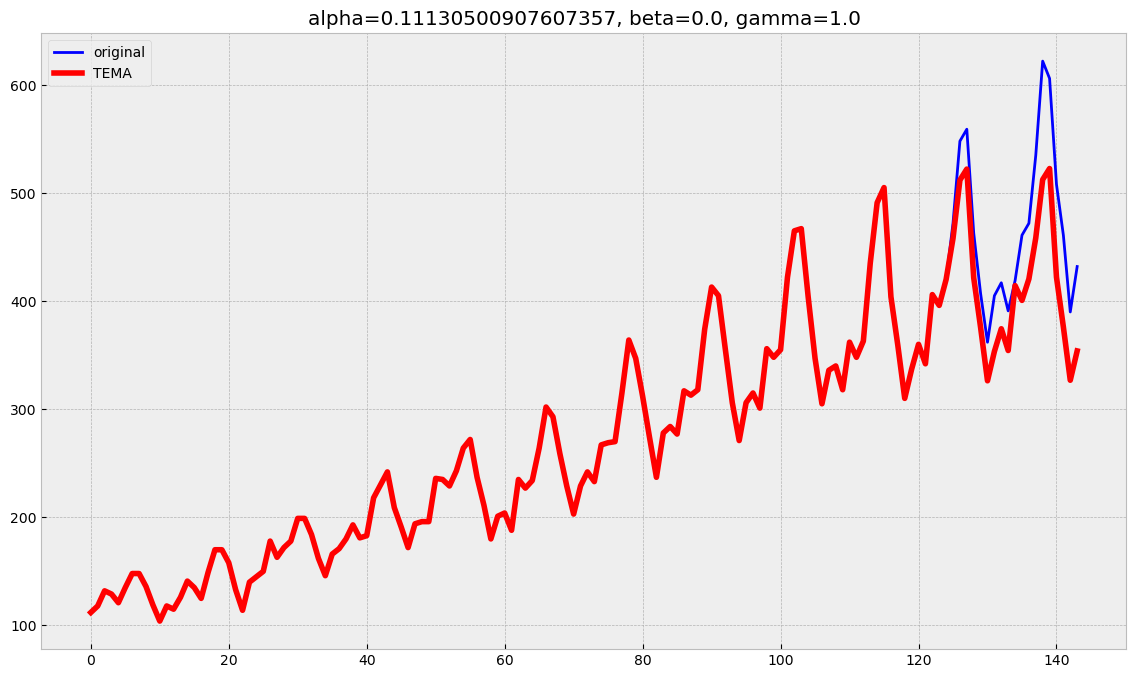

In [33]:
plot_tema(alpha_opt, beta_opt, gamma_opt, ser=train, ser_to_plot=series, n_preds=len(val))

при кросс- валидации осталась созонностьи ушел тренд. Результат подбора параметров хуже , чем при минимизации 𝑅𝑀𝑆𝐸